In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf

In [0]:
import re
import nltk
import string
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

In [0]:
train=pd.read_csv('/content/drive/My Drive/Twitter Sentiment/train.csv')

In [24]:
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0,factsguide: society now #motivation


In [25]:
len(train)

31962

In [26]:
train['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

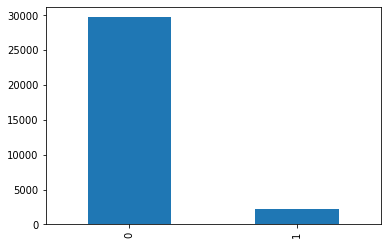

In [27]:
train['label'].value_counts().plot(kind='bar')

In [0]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt

In [0]:
train['tidy_tweet'] = np.vectorize(remove_pattern)(train['tweet'], "@[\w]*") 

In [0]:
train['tidy_tweet'] = train['tidy_tweet'].str.replace("[^a-zA-Z]", " ")

In [0]:
train['tidy_tweet'] = train['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [0]:
tokenized_tweet = train['tidy_tweet'].apply(lambda x: x.split())

In [0]:
from nltk.stem.porter import * 
stemmer = PorterStemmer() 
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])

In [0]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])    
train['tidy_tweet'] = tokenized_tweet

In [0]:
tokenized_tweet = list(train['tidy_tweet'])

In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [0]:
tk = Tokenizer(lower=True, filters='')
tk.fit_on_texts(tokenized_tweet)

max_len = 120
train_tokenized = tk.texts_to_sequences(tokenized_tweet)
X = pad_sequences(train_tokenized, maxlen=max_len)

In [38]:
X.shape

(31962, 120)

In [41]:
tokenized_tweet[0],tokenized_tweet[1]

('when father dysfunct selfish drag kid into dysfunct',
 'thank lyft credit caus they offer wheelchair van disapoint getthank')

In [42]:
X[0],X[1]

(array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,   11,   20, 4757, 1922, 1648,  177,  191, 4757],
       dtype=int32),
 array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
y=train['label']

In [0]:
X_train,X_valid,y_train,y_valid=train_test_split(X,y,test_size=0.2)

In [0]:
vocab_size=X.max()+1

In [49]:
vocab_size

29580

In [0]:
from tensorflow.keras.layers import Embedding,LSTM,Bidirectional,Dense,Dropout
from tensorflow.keras.models import Sequential

In [0]:
model=Sequential()

model.add(Embedding(vocab_size,64,input_length = X.shape[1]))
model.add(Bidirectional(LSTM(64,return_sequences=True)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.33))

model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam')

In [53]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 64)           1893120   
_________________________________________________________________
bidirectional (Bidirectional (None, 120, 128)          66048     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 2,004,609
Trainable params: 2,004,609
Non-trainable params: 0
______________________________________________

In [0]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',patience=2)

In [58]:
model.fit(X_train,y_train,epochs=5,
          validation_data=(X_valid,y_valid),
          callbacks=[early_stop])

Train on 25569 samples, validate on 6393 samples
Epoch 1/5
25569/25569 [==============================] - 36s 1ms/sample - loss: 0.1769 - val_loss: 0.1255
Epoch 2/5
25569/25569 [==============================] - 32s 1ms/sample - loss: 0.0815 - val_loss: 0.1316
Epoch 3/5
25569/25569 [==============================] - 33s 1ms/sample - loss: 0.0441 - val_loss: 0.1390


In [0]:
metrics=pd.DataFrame(model.history.history)

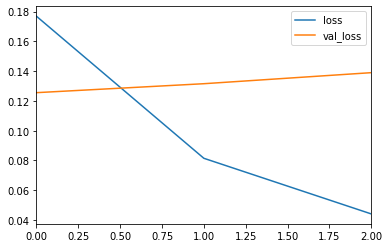

In [60]:
metrics.plot()

In [64]:
model.evaluate(X_valid,y_valid)

6393/6393 [==============================] - 2s 312us/sample - loss: 0.1390


0.13897596163413406

In [0]:
pred=model.predict(X_valid)

In [0]:
y_pred=[]
for i in pred:
  if i>0.5:
    y_pred.append(1)
  else:
    y_pred.append(0)

In [0]:
from collections import Counter

In [71]:
Counter(y_valid)

Counter({0: 5942, 1: 451})

In [72]:
Counter(y_pred)

Counter({0: 6004, 1: 389})

In [0]:
from sklearn.metrics import classification_report

In [74]:
print(classification_report(y_valid,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      5942
           1       0.72      0.62      0.66       451

    accuracy                           0.96      6393
   macro avg       0.84      0.80      0.82      6393
weighted avg       0.95      0.96      0.95      6393



In [0]:
y_pred_classes=model.predict_classes(X_valid)

In [76]:
print(classification_report(y_valid,y_pred_classes))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      5942
           1       0.72      0.62      0.66       451

    accuracy                           0.96      6393
   macro avg       0.84      0.80      0.82      6393
weighted avg       0.95      0.96      0.95      6393



In [0]:
test=pd.read_csv('/content/drive/My Drive/Twitter Sentiment/test.csv')

In [78]:
test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedication #willpower to find #newmaterialsâ¦
1,31964,@user #white #supremacists want everyone to see the new â #birdsâ #movie â and hereâs why
2,31965,safe ways to heal your #acne!! #altwaystoheal #healthy #healing!!
3,31966,"is the hp and the cursed child book up for reservations already? if yes, where? if no, when? ððð #harrypotter #pottermore #favorite"
4,31967,"3rd #bihday to my amazing, hilarious #nephew eli ahmir! uncle dave loves you and missesâ¦"


In [102]:
test.shape

(17197, 3)

In [0]:
test['tidy_tweet'] = np.vectorize(remove_pattern)(test['tweet'], "@[\w]*") 

In [0]:
test['tidy_tweet'] = test['tidy_tweet'].str.replace("[^a-zA-Z]", " ")

In [0]:
test['tidy_tweet'] = test['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [0]:
tokenized_test = test['tidy_tweet'].apply(lambda x: x.split())

In [0]:
from nltk.stem.porter import * 
stemmer = PorterStemmer() 
tokenized_test = tokenized_test.apply(lambda x: [stemmer.stem(i) for i in x])

In [0]:
for i in range(len(tokenized_test)):
    tokenized_test[i] = ' '.join(tokenized_test[i])    
test['tidy_tweet'] = tokenized_test

In [0]:
tokenized_test = list(test['tidy_tweet'])

In [0]:
test_tokenized=tk.texts_to_sequences(tokenized_test)
X_test = pad_sequences(test_tokenized, maxlen=max_len)

In [88]:
X_test.shape

(17197, 120)

In [0]:
y_test=model.predict_classes(X_test)

In [0]:
submission=pd.DataFrame(test['id'],columns=['id'])

In [96]:
submission.head()

,id
0,31963
1,31964
2,31965
3,31966
4,31967


In [0]:
submission['label']=y_test

In [98]:
submission.head()

,id,label
0,31963,0
1,31964,0
2,31965,0
3,31966,0
4,31967,0


In [99]:
Counter(submission['label'])

Counter({0: 16239, 1: 958})

In [0]:
submission.to_csv('sub.csv',index=False)

In [101]:
submission.shape

(17197, 2)

In [0]:
model.save('twitter.h5')

In [0]:
import re
import tweepy
from tweepy import OAuthHandler
from textblob import TextBlob
from datetime import datetime
import pytz

In [0]:
class TwitterClient(object):
    '''
    Generic Twitter Class for sentiment analysis.
    '''
    def __init__(self):
        '''
        Class constructor or initialization method.
        '''
        # keys and tokens from the Twitter Dev Console
        consumer_key = 'WUvidcRYWx9lFraEnDM9IVmOj'
        consumer_secret = 'syWCimyeiRa0IXQtxyaFMcTdQVYcCoW1ZapP3UhIiaFJbw5OK1'
        access_token = '1021322387474829312-MY9QylZjprWICeitAs4BAdCmPADzyj'
        access_token_secret = '2dF1x0MuuMXnKSDnDU7csLxQkuGD7FSPZbuW8bnz776NX'
 
        # attempt authentication
        try:
            # create OAuthHandler object
            self.auth = OAuthHandler(consumer_key, consumer_secret)
            # set access token and secret
            self.auth.set_access_token(access_token, access_token_secret)
            # create tweepy API object to fetch tweets
            self.api = tweepy.API(self.auth)
        except:
            print("Error: Authentication Failed")
 
    def clean_tweet(self, tweet):
        '''
        Utility function to clean tweet text by removing links, 
        special characters
        using simple regex statements.
        '''
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())
 
    def get_tweets(self, query, count):
        '''
        Main function to fetch tweets and parse them.
        '''
        # empty list to store parsed tweets
        tweets = []
 
        try:
            # call twitter api to fetch tweets
            fetched_tweets = self.api.search(q = query, count = count, lang = 'en')
 
            # parsing tweets one by one
            for tweet in fetched_tweets:
                # empty dictionary to store required params of a tweet
                parsed_tweet = []
 
                # saving text of tweet
                parsed_tweet.append(tweet.text)
 
                # appending parsed tweet to tweets list
                if tweet.retweet_count > 0:
                    # if tweet has retweets, ensure that it is appended only once
                    if parsed_tweet not in tweets:
                        tweets.append(parsed_tweet)
                else:
                    tweets.append(parsed_tweet)
 
            # return parsed tweets
            return tweets
 
        except tweepy.TweepError as e:
            # print error (if any)
            print("Error : " + str(e))


In [0]:
tz_IND = pytz.timezone('Asia/Kolkata')

In [226]:
api = TwitterClient()
    # calling function to get tweet

now = datetime.now(tz_IND)
current_time = now.strftime("%d-%m-%Y %H:%M:%S")
keyword=input()
#n=int(input())
tweets = api.get_tweets(query = keyword, count = 1000)

Corona Virus


In [0]:
tweets_df=pd.DataFrame(tweets,columns=['tweet'])

In [0]:
def embed(inp):
  predict_tweet = np.vectorize(remove_pattern)(inp, "@[\w]*")
  predict_tweet=pd.DataFrame(predict_tweet,columns=['tweets'])
  predict_tweet['tweets'] = predict_tweet['tweets'].str.replace("[^a-zA-Z]", " ")
  predict_tweet['tweets'] = predict_tweet['tweets'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
  tokens = predict_tweet['tweets'].apply(lambda x: x.split())
  tokens = tokens.apply(lambda x: [stemmer.stem(i) for i in x])
  for i in range(len(tokens)):
    tokens[i] = ' '.join(tokens[i])    
  predict_tweet['tweets'] = tokens

  to_embed = list(tokens)
  for_embed=tk.texts_to_sequences(to_embed)
  
  X_to_pred = pad_sequences(for_embed, maxlen=max_len)
  return X_to_pred

In [0]:
X_to_pred=embed(tweets_df['tweet'])

In [0]:
new_pred=model.predict_classes(X_to_pred)

In [0]:
final_pred=new_pred.reshape(len(new_pred))

In [0]:
negative=list(final_pred).count(1)
positive=list(final_pred).count(0)

In [234]:
print(f'On date and time: {current_time}, the sentiment for {keyword} is-')
print(f'Positive Percentage: {100 * positive/len(final_pred)}%')
print(f'Negative Percentage: {100 * negative/len(final_pred)}%')

On date and time: 09-03-2020 17:01:58, the sentiment for Corona Virus is-
Positive Percentage: 98.30508474576271%
Negative Percentage: 1.694915254237288%
